In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import pandas as pd
import pathlib
from tqdm.autonotebook import tqdm
from sklearn import tree

/tmp/ipykernel_19523/2678709462.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# OpenCV Fast Fourier Transform (FFT) for blur detection in images

Code taken from https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/

In [2]:
def detect_blur_fft(image, size=60, thresh=10, vis=False):
	"""
	@image: input image for blur detection (BGR numpy array)
	@size: size of the radius around the centerpoint of the image for which we will zero out the FFT shift
	@thresh: value which the mean value of the magnitudes (more on that later) will be compared to for determining whether an image is considered blurry or not blurry
	@vis: boolean indicating whether to visualize/plot the original input image and magnitude image using matplotlib
	"""

	# resize the image and convert to grayscale
	image = imutils.resize(image, width=500)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# grab the dimensions of the image and use the dimensions to
	# derive the center (x, y)-coordinates
	(h, w) = image.shape
	(cX, cY) = (int(w / 2.0), int(h / 2.0))

    # compute the FFT to find the frequency transform, then shift
	# the zero frequency component (i.e., DC component located at
	# the top-left corner) to the center where it will be more
	# easy to analyze
	fft = np.fft.fft2(image)
	fftShift = np.fft.fftshift(fft)

    # check to see if we are visualizing our output
	if vis:
		# compute the magnitude spectrum of the transform
		magnitude = 20 * np.log(np.abs(fftShift))
		# display the original input image
		(fig, ax) = plt.subplots(1, 2, )
		ax[0].imshow(image, cmap="gray")
		ax[0].set_title("Input")
		# ax[0].set_xticks([])
		# ax[0].set_yticks([])
		# display the magnitude image
		ax[1].imshow(magnitude, cmap="gray")
		ax[1].set_title("Magnitude Spectrum")
		# ax[1].set_xticks([])
		# ax[1].set_yticks([])
		# show our plots
		plt.show()
    
    # zero-out the center of the FFT shift (i.e., remove low
	# frequencies), apply the inverse shift such that the DC
	# component once again becomes the top-left, and then apply
	# the inverse FFT
	fftShift[cY - size:cY + size, cX - size:cX + size] = 0
	fftShift = np.fft.ifftshift(fftShift)
	recon = np.fft.ifft2(fftShift)

    # compute the magnitude spectrum of the reconstructed image,
	# then compute the mean of the magnitude values
	magnitude = 20 * np.log(np.abs(recon))
	mean = np.mean(magnitude)
	# the image will be considered "blurry" if the mean value of the
	# magnitudes is less than the threshold value
	return (mean, mean <= thresh)

# Laplacian variance method for blur detection in images

In [3]:
def detect_blur_laplacian(img, threshold, rescale=True):
    """
    @img: input image for blur detection (BGR numpy array)
    @threshold: value which the mean value of the laplacian will be compared to for determining whether an image is considered blurry or not blurry
    """
    if rescale:
        img = imutils.resize(img, width=500)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return (fm, fm < threshold)

# Performance on blur dataset (https://www.kaggle.com/datasets/kwentar/blur-dataset)

In [4]:
# load all the images to a dataframe
#   blur_dataset_scaled/defocused_blurred   --> blurry
#   blur_dataset_scaled/motion_blurred      --> blurry
#   blur_dataset_scaled/sharp               --> not blurry

# load all img into a dataframe

datasets = [
    ("blur_dataset_scaled/defocused_blurred", True),
    ("blur_dataset_scaled/motion_blurred", True),
    ("blur_dataset_scaled/sharp", False)
]

res = {}

for dataset, blur_target in datasets:
    dataset_folder = pathlib.Path(dataset)

    df = pd.DataFrame(columns=['img_path', 'img', 'blur_target'])
    for img_path in tqdm(list(dataset_folder.iterdir())):
        img = cv2.imread(str(img_path)) # cv2 load image as BGR
        new_row = {'img_path': str(img_path), 'img': [img], 'blur_target': blur_target}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        # break
    
    df[["mean_fft", "blurry_fft"]] = df["img"].apply(lambda x: pd.Series(detect_blur_fft(x, size=60, thresh=10, vis=False)))
    df[["fm_laplacian_rescaled", "blurry_laplacian_rescaled"]] = df["img"].apply(lambda x: pd.Series(detect_blur_laplacian(x, threshold=100)))
    df[["fm_laplacian", "blurry_laplacian"]] = df["img"].apply(lambda x: pd.Series(detect_blur_laplacian(x, threshold=100, rescale=False)))

    df["fft_match"] = df["blur_target"] == df["blurry_fft"]
    df["laplacian_match"] = df["blur_target"] == df["blurry_laplacian"]
    df["laplacian_rescaled_match"] = df["blur_target"] == df["blurry_laplacian_rescaled"]

    res[dataset] = {
        "fft" : df["fft_match"].mean(),
        "laplacian" : df["laplacian_match"].mean(),
        "laplacian_rescaled" : df["laplacian_rescaled_match"].mean()
    }

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

In [5]:
# convert res to dataframe
df_res = pd.DataFrame(res).T
df_res

,fft,laplacian,laplacian_rescaled
blur_dataset_scaled/defocused_blurred,0.877143,0.797143,0.962857
blur_dataset_scaled/motion_blurred,0.677143,0.648571,0.691429
blur_dataset_scaled/sharp,0.914286,0.842857,0.951429


# Sample on La Liberté

In [15]:
def compare_blur_detection(img_path: str, plot=True):
    img = cv2.imread(img_path) # cv2 load image as BGR

    ftt_threshold = 15.579238414764404
    laplacian_threshold = 165.1521759033203

    mean, blur_ftt = detect_blur_fft(img, size=60, thresh=ftt_threshold, vis=False)
    # fm, blur_laplacian = detect_blur_laplacian(img, threshold=165.1521759033203, rescale=False)
    fm_rescaled, blur_laplacian_rescaled = detect_blur_laplacian(img, threshold=laplacian_threshold)

    if plot:

        # plt subplots 1x3
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # plot original image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[0].imshow(img_rgb)
        ax[0].set_title("Original Image")

        # plot rescalled image
        img_rescaled = imutils.resize(img, width=500)
        gray = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
        ax[1].imshow(gray, cmap="gray")
        ax[1].set_title("Rescaled gray Image")

        def is_blurry(fft, laplacian_rescaled):
            if (fft > ftt_threshold) or (laplacian_rescaled > laplacian_threshold):
                return "Not blurry"
            elif (fft > 10) and (laplacian_rescaled > 100):
                return "Not Blurry"
            else:
                return "blurry"

        # plot text with blur detection results
        text = f"""
        FFT: {mean:.3f}
        Laplacian: {fm_rescaled:.3f}
        Decision: {is_blurry(mean, fm_rescaled)}
        """
        ax[2].text(0, 0.5, text, fontsize=12, ha='left', va='center')
        ax[2].set_title("Blur Detection Results")
        ax[2].axis('off')

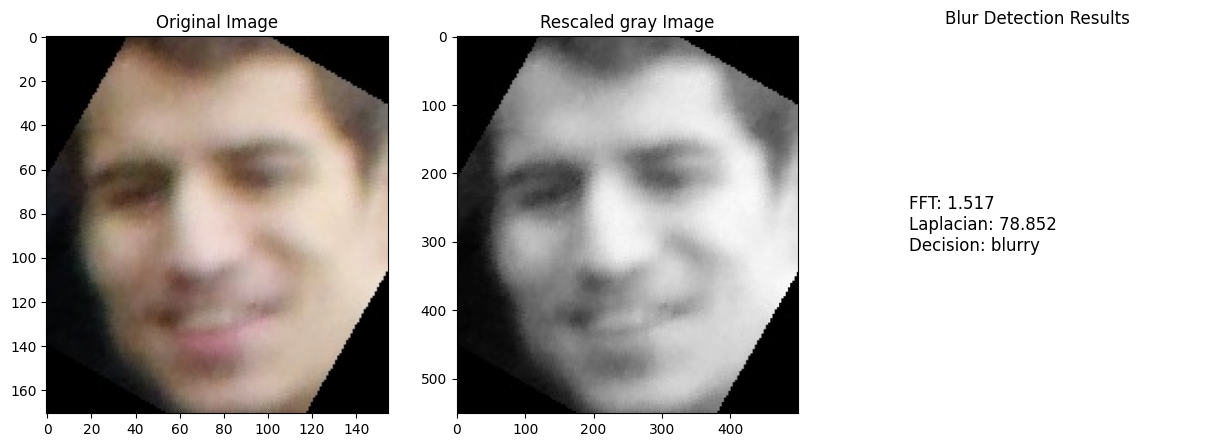

In [16]:
compare_blur_detection("../dataset/faces_bkp/0DpWZ7_Iq6Q9g8TgaYxRxP_f6.jpg")

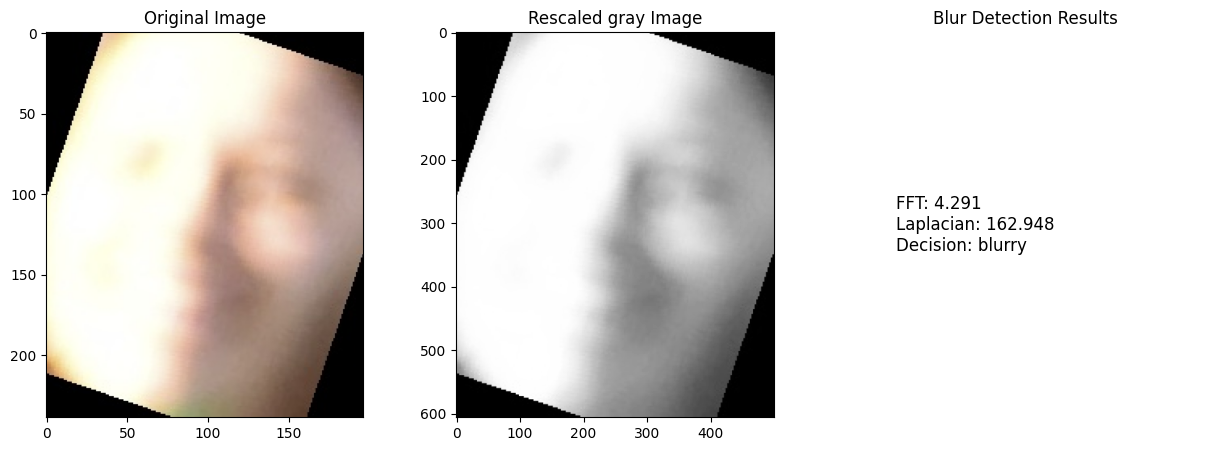

In [17]:
compare_blur_detection("../dataset/faces_bkp/Ez2TRtoOq1iAn3wr8vTYvV_f0.jpg")

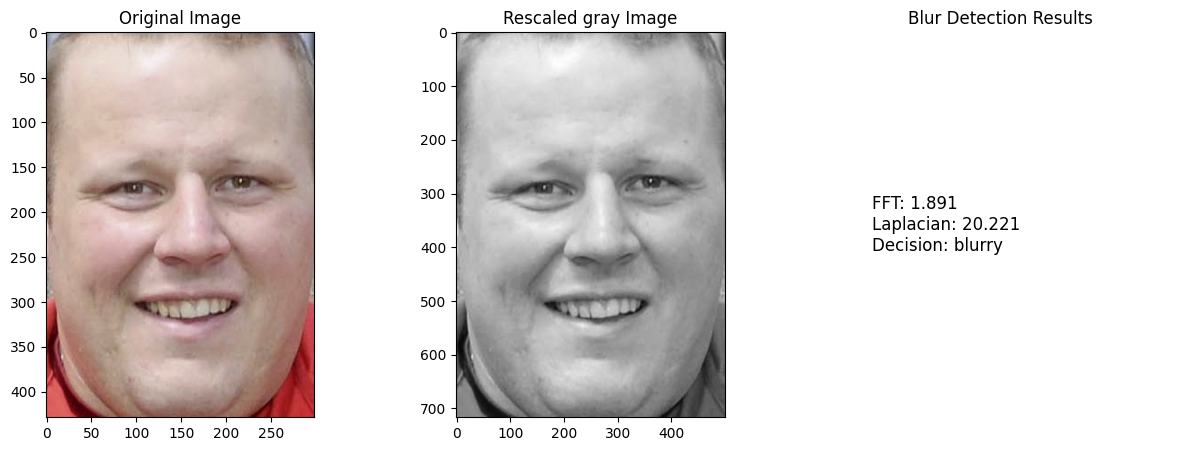

In [18]:
compare_blur_detection("../dataset/faces_bkp/EuBGFSXo4PwBoznhQk4v5N_f2.jpg")

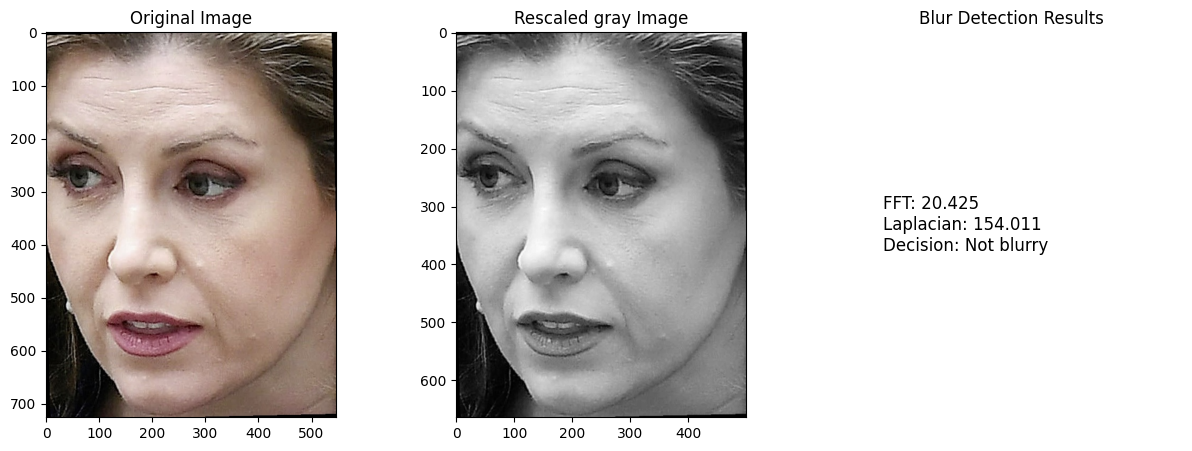

In [19]:
compare_blur_detection("../dataset/faces_bkp/0_-M9l7X4fzA-gSGd--qsI_f0.jpg")

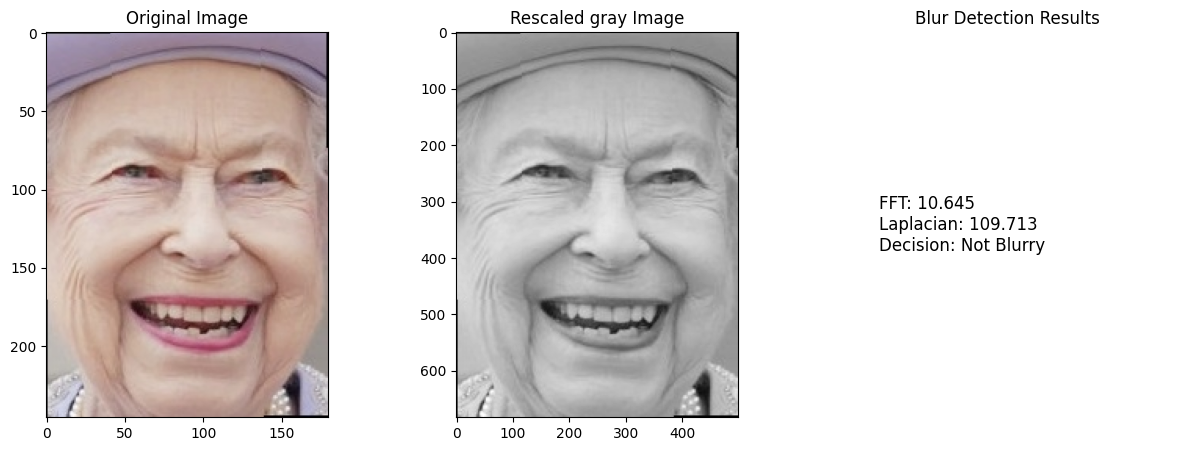

In [20]:
compare_blur_detection("../dataset/faces_bkp/1wBlltV8K9m8vFaKMe2wF6_f0.jpg")

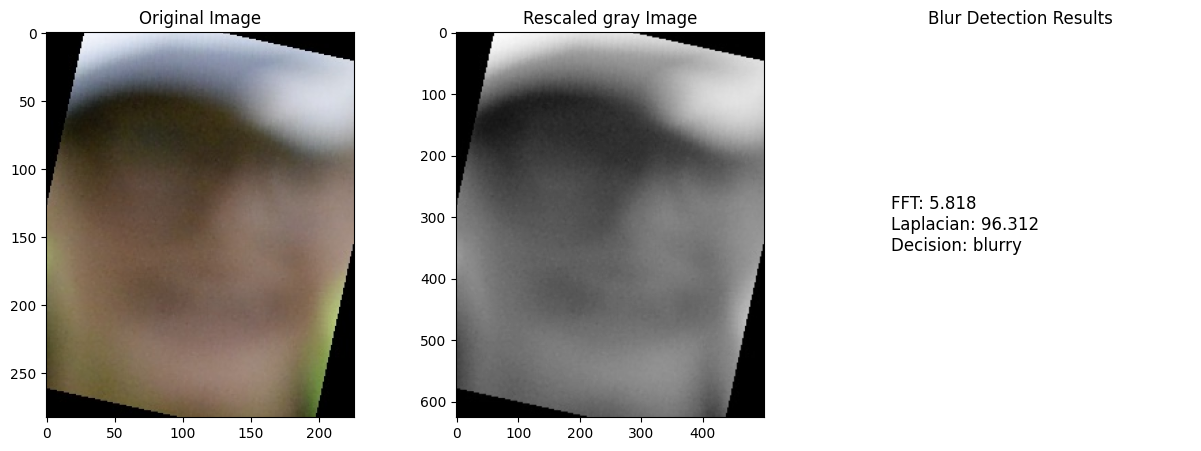

In [21]:
compare_blur_detection("../dataset/faces_bkp/FmTY6dyL4s0Bs1_QqGCkLU_f2.jpg")

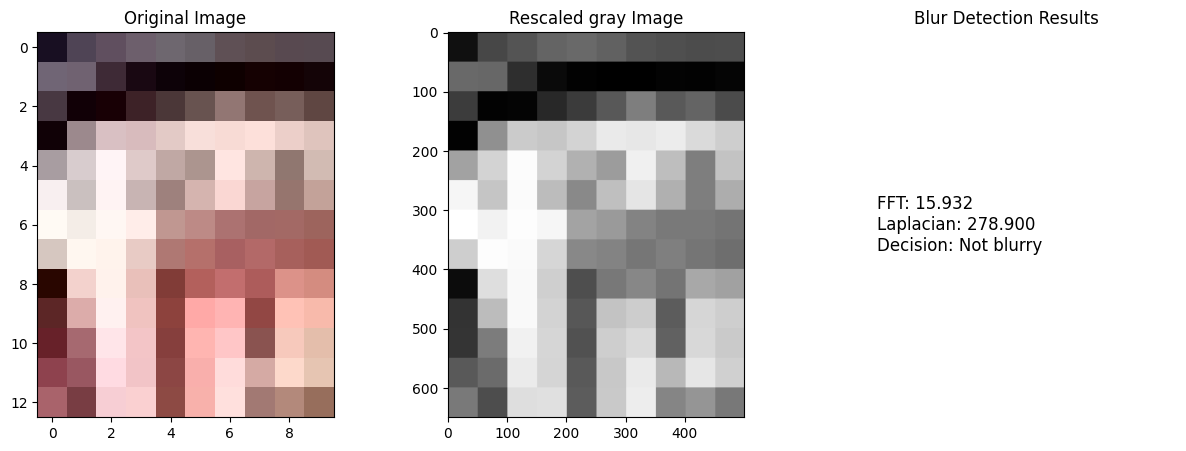

In [22]:
compare_blur_detection("../dataset/faces_bkp/0589W7FPKO8AqxaUwIBStC_f4.jpg")

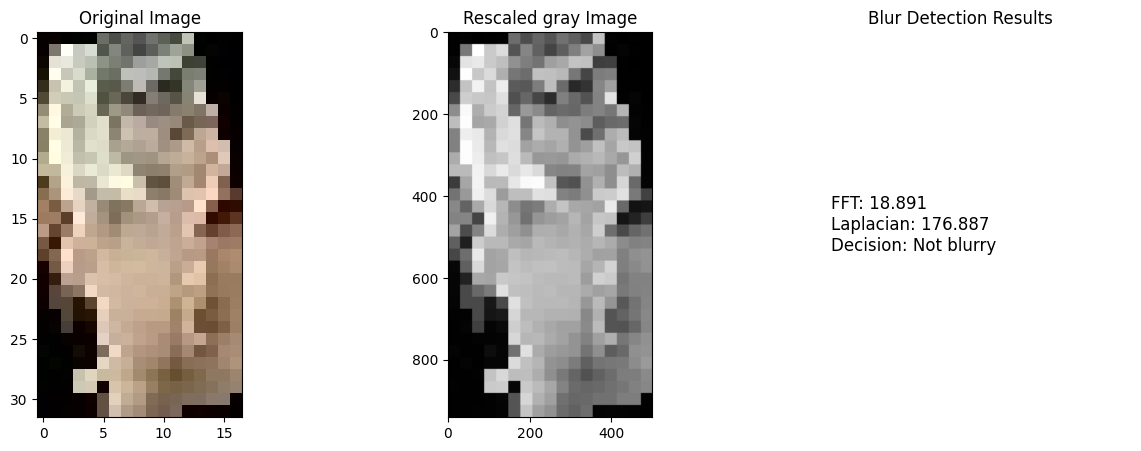

In [23]:
compare_blur_detection("../dataset/faces_bkp/5SYsf_yRafI9q1txsLArPE_f11.jpg")

# Finding the best threshold

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import pandas as pd
import pathlib
from tqdm.autonotebook import tqdm
from sklearn import tree

In [5]:
# load all the images to a dataframe
#   blur_dataset_scaled/defocused_blurred   --> blurry
#   blur_dataset_scaled/motion_blurred      --> blurry
#   blur_dataset_scaled/sharp               --> not blurry

# load all img into a dataframe

datasets = [
    ("blur_dataset_scaled/defocused_blurred", True),
    ("blur_dataset_scaled/motion_blurred", True),
    ("blur_dataset_scaled/sharp", False)
]

res = {}
df = pd.DataFrame(columns=['img_path', 'img', 'blur_target'])
for dataset, blur_target in datasets:
    dataset_folder = pathlib.Path(dataset)

    
    for img_path in tqdm(list(dataset_folder.iterdir())):
        img = cv2.imread(str(img_path)) # cv2 load image as BGR
        new_row = {'img_path': str(img_path), 'img': [img], 'blur_target': blur_target}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        # break

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

In [6]:
df[["mean_fft", "blurry_fft"]] = df["img"].apply(lambda x: pd.Series(detect_blur_fft(x, size=60, thresh=10, vis=False)))
df[["fm_laplacian_rescaled", "blurry_laplacian_rescaled"]] = df["img"].apply(lambda x: pd.Series(detect_blur_laplacian(x, threshold=100)))
# df[["fm_laplacian", "blurry_laplacian"]] = df["img"].apply(lambda x: pd.Series(detect_blur_laplacian(x, threshold=100, rescale=False)))

In [10]:
X = df[["mean_fft", "fm_laplacian_rescaled"]].to_numpy()
y = df["blur_target"].apply(lambda x: 1 if x else -1).to_numpy()

Score: 0.8990476190476191
Threshold: 165.1521759033203


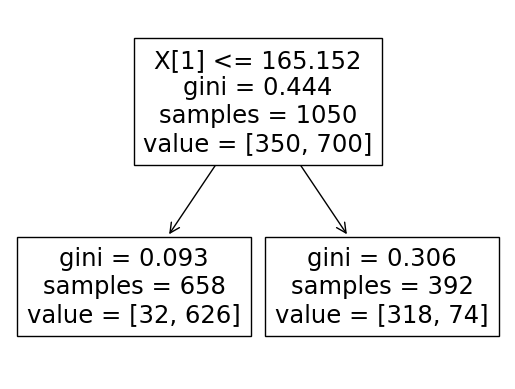

In [12]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X, y)
# score
print(f"Score: {clf.score(X, y)}")
tree.plot_tree(clf)
# get the threshold
print(f"Threshold: {clf.tree_.threshold[0]}")

Score: 0.8666666666666667
Threshold: 15.579238414764404


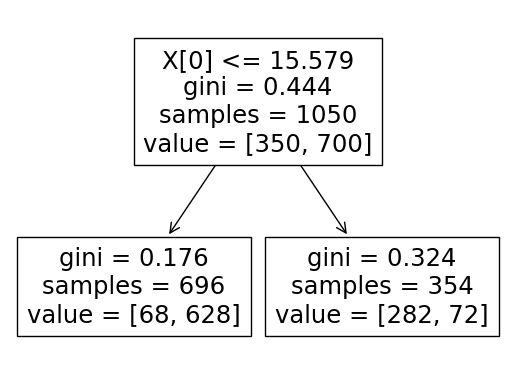

In [18]:
df[["mean_fft", "blurry_fft"]] = df["img"].apply(lambda x: pd.Series(detect_blur_fft(x, size=60, thresh=10, vis=False)))

X = df[["mean_fft"]].to_numpy().reshape(-1, 1)
y = df["blur_target"].apply(lambda x: 1 if x else -1).to_numpy()

clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X, y)
# score
print(f"Score: {clf.score(X, y)}")
tree.plot_tree(clf)
# get the threshold
print(f"Threshold: {clf.tree_.threshold[0]}")